# Detekce bakterií z fotografie vzorku

### Datový sešit

#### Nahrání závislostí

In [ ]:
!python3 -m pip install numpy
!python3 -m pip install matplotlib
!python3 -m pip install scikit-image
!python3 -m pip install opencv-python

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters
import skimage.color
import skimage.io
import skimage.morphology
import skimage.util
import cv2
import os
from os import path

#### Příprava adresářové struktury

In [133]:
#nazev konkretniho snimku, ktery analyzujeme
image_filename = 'image000.jpeg'

#adresar, ve kterym jsou ulozene snimky bunek v Petriho misce
image_folder = 'images'

#pokud neexistuje adresar pro nacitani fotografii
if not path.exists(image_folder):
    #tak vyhod vyjimku a ukonci program
    raise Exception("CHYBA: Zvoleny adresar pro nacitani fotografii neexistuje!")

#adresar, do ktereho se ukladaji fotografie
save_folder = 'analyses'

#pokud neexistuje adresar pro ukladani fotografii
if not path.exists(save_folder):
    #tak ho vytvor
    os.makedirs(save_folder)

#### Nahrání fotografie

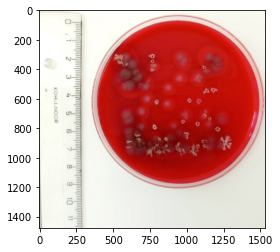

In [148]:
#nacteni fotografie do pameti, bohuzel se nactou spatne barvy (cervena bude modra, =BGR format)
original_image = cv2.imread(path.join(image_folder, image_filename))

#oprava barev z BGR formatu na RGB format
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

#zobrazeni fotografie pro kontrolu korektniho nacteni a prevodu barev
plt.imshow(original_image)

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'original_'+image_filename))

#### Nalezení okraje misky

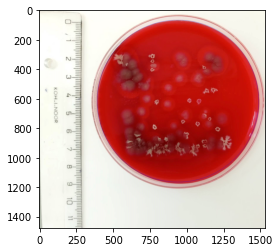

In [149]:
#udelame si kopii snimku, se kterou budeme pracovat
image = original_image              

#minimalni polomer okraje misky, nastavujeme ho proto, at to neoznaci i bakterie jako kruznice
min_radius = 500

#maximalni polomer okraje misky
max_radius = 550

#barva kruznice, ktera vyznaci misku, tuto barvu pak pouzijeme pro odstraneni pozadi misky
circle_color = (0, 0, 255)

#prevedeni obrazku na cernobily pro detekci okraje
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#rozmazani obrazku pro detekci okraje
gray_blurred = cv2.bilateralFilter(gray, 11, 30, 30)

#nalezni kruznici v rozmezni velikosti polomeru misky (bunky jsou prilis male aby je zachytil)
detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, param1=50, param2=30,
                    minDist=100, minRadius=min_radius, maxRadius=max_radius)

#pokud byla nejaka kruznice nalezena
if detected_circles is not None:
    
    #preved parametry kruznice na cela cisla (souradnice pixelu jsou cela cisla)
    detected_circles = np.uint16(np.around(detected_circles))

    #pro kazdou nalezenou kruznici (mela by byt jen jedna)
    for pt in detected_circles[0, :]:

        #ziskej souradnice jejiho stredu a,b a polomer r
        a, b, r = pt[0], pt[1], pt[2]

        #nakresli do obrazku takovou kruznici pomoci vyznacujici barvy
        cv2.circle(image, (a, b), r, circle_color, thickness=1)

#zobraz obrazek s vyznacenym okrajem misky pro kontrolu
plt.imshow(image)

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'circle_'+image_filename))

#### Odstranění okraje misky

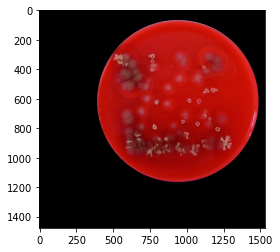

In [150]:
#barva, na kterou budeme obarvovat pozadi (cerna)
fill_color = (0, 0, 0)

#barva, kterou ma vyznacovaci kruznice; pokud ji nalezneme, prestaneme obarvovat pozadi a skocima na dalsi radek
stop_color = circle_color

#zjistime vysku, sirku a pocet barev obrazku (pocet barev=kanalu nebudeme potrebovat)
height, width, channels = image.shape

#zacneme od prvniho radku zleva a obarvujeme pixely, dokavad nenalezneme okraj vyznacovaci kruznice
#projedeme kazdy radek
for y in range(height):
    #v kazdem radku projedeme postupne vsechny pixelu
    for x in range(width):
        #pokud se barva aktualniho pixelu rovna barve vyznacovaci kruznice
        if all([image[y][x][channel] == stop_color[channel] for channel in range(3)]):
            #obarvi jeste tento pixel at kruznice zmizi a skoc na dalsi radek
            image[y][x] = fill_color
            break
        else:
            #jinak obarvy pozadi
            image[y][x] = fill_color

#zacneme od prvniho radku zleva a obarvujeme pixely, dokavad nenalezneme okraj vyznacovaci kruznice
for y in range(height):
    for x in range(width-1, -1, -1):
        if all([image[y][x][channel] == stop_color[channel] for channel in range(3)]):
            image[y][x] = fill_color
            break
        else:
            image[y][x] = fill_color

#zobraz obrazek s odstranenym pozadim misky pro kontrolu
plt.imshow(image)

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'cropped_'+image_filename))

#### Převod mezi formáty obrázků

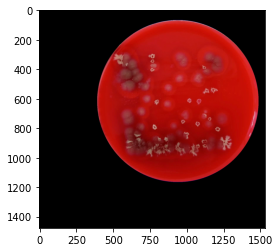

In [151]:
#nahraj obrazek z open-cv knihovny do skimage knihovny
image = skimage.util.img_as_float(image)

#zobraz obrazek na obrazovku pro kontrolu korektniho prevodu
plt.imshow(image)

#### Převod do odstínu šedi

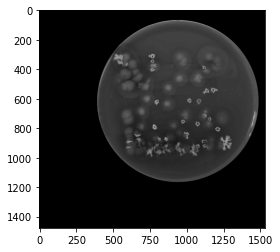

In [152]:
#preved obrazek do odstinu sedi
grayscale_image = skimage.color.rgb2gray(image)

#zobraz na obrazovku (mapa barev sediva, protoze imshow si stejne zvoli nejake vlastni barvy pro vykresleni)
plt.imshow(grayscale_image, cmap="gray")

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'grayscale_'+image_filename))

#### Rozmazání obrázku

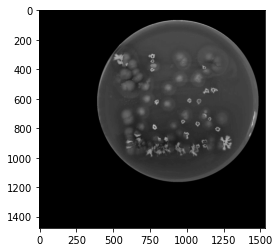

In [153]:
#koeficient rozmazani obrazku - smaze sum typu sul a pepr
sigma = 1.0

#vytvor rozmazeny obrazek o zvolene mire rozmazanosti
blurred_image = skimage.filters.gaussian(grayscale_image, sigma=sigma)

#zobraz rozmazany obrazek na obrazovku pro kontrolu
plt.imshow(blurred_image, cmap="gray")

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'blurred_'+image_filename))

#### Vykreslení histogramu intenzity pixelů

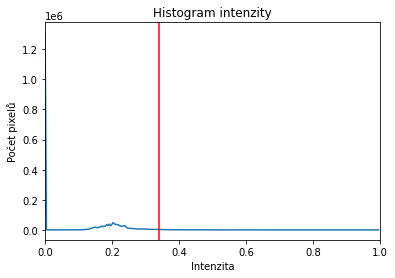

<Figure size 432x288 with 0 Axes>

In [154]:
#nastav prah intenzity pixelu, od ktereho odstran pixely (relativně od 0=min do 1=max)
threshold = 0.34

#pocet binu na histogramu, urcuje hustotu deleni
nbins = 256

#vytvor histogram intenzity poctu pixelu (y) o dane intenzite pixelu (x0 z rozmazaneho obrazu
histogram, bin_edges = np.histogram(blurred_image, bins=nbins, range=(0.0, 1.0))

#vytvor histogram, na ose x jsou biny, na ose y jsou data histogramu
plt.plot(bin_edges[0:-1], histogram)

#vykresli vertikalni cervenou caru na bod na ose x, kde byl zvolen prah
plt.axvline(x=threshold, color='r')

#nazev grafu
plt.title('Histogram intenzity')

#popisek osy x
plt.xlabel("Intenzita")

#popisek osy y
plt.ylabel("Počet pixelů")

#rozsah na ose x (hodnoty od 0 do 1)
plt.xlim(0, 1.0)

#zobraz histogram na obrazovku
plt.show()

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'histogram'+image_filename))

#### Filtrace podle prahu intenzity

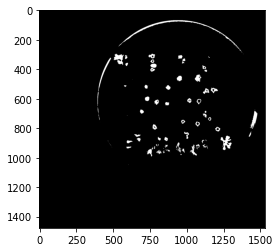

In [155]:
#vytvor masku, ktera zakryje vsechny pixely, majici intenzitu mensi jak prah, vetsi jak prah jsou bile diry
mask = blurred_image > threshold

#zobraz masku pro kontrolu
plt.imshow(mask, cmap="gray")

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'mask_'+image_filename))

#### Morfologická úprava

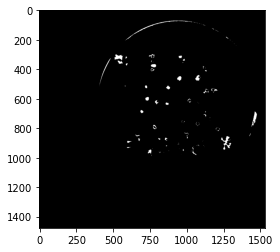

In [156]:
#nastav silu morfologickeho operatoru eroze
morphdisk = 3

#proved operaci eroze, ktera oddeli od sebe bunky na mensi
morphed_image = skimage.morphology.erosion(mask, footprint=skimage.morphology.disk(morphdisk))

#zobraz obrazek po erozi pro kontrolu
plt.imshow(morphed_image, cmap="gray")

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'morphed_'+image_filename))

#### Počítání bakterií vybarvováním

Napočítáno 139 kolonií bakterií v obrázku: image000.jpeg


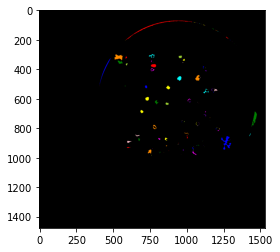

In [157]:
#oznac odkryta mista pod maskou znackou (=cislo) a zjisti, kolik znacek jsi potreboval
labeled_image, count = skimage.measure.label(morphed_image, return_num=True)

#pocet snizime o jednicku, jelikoz program pocita pozadi take jako bunku
count -= 1

#preved znacky na barvy a obarvi s nimi odkryta mista
colored_label_image = skimage.color.label2rgb(labeled_image, bg_label=0)

#zobraz obrazek s obarvenymi koloniemi na obrazovku pro kontrolu
plt.imshow(colored_label_image)

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'colored_'+image_filename))

#### Proložení vybarveného na černobílý obrázek

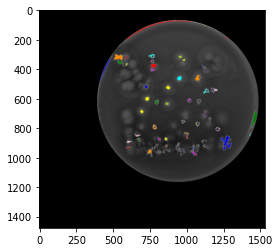

In [158]:
#vezmem cernobily obrazek jako zaklad, umele mu dame 3 kanaly z puvodniho jednoho
summary_image = skimage.color.gray2rgb(grayscale_image)

#prilozime na cernobily obrazek masku a odkryta mista prebarvime barvami z oznackovaneho obrazku
summary_image[morphed_image] = colored_label_image[morphed_image]

#souhrnny obrazek vykreslime na obrazovku pro kontrolu
plt.imshow(summary_image)

#ulozeni fotografie na disk
plt.savefig(path.join(save_folder, 'summary_'+image_filename))